## **Making embeddings for Cora**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

import gensim
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

In [66]:
# Load dataset
dataset = pd.read_csv("../Cora_dataset.csv")

# Load pretrained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True)

### **Word2Vec embeddings**

In [67]:
dataset = dataset.dropna(subset=["Abstract"]).reset_index(drop=True)

# Get embedding for a single abstract
def abstract_to_w2v(abstract, w2v_model, vector_size=300):
    # Tokenize by simple whitespace and lowercase
    tokens = abstract.lower().split()
    # Filter tokens that exist in the Word2Vec vocabulary
    valid_tokens = [t for t in tokens if t in w2v_model]
    
    if not valid_tokens:  # If no tokens are in the vocab, return zeros
        return np.zeros(vector_size)
    
    # Average embeddings
    embeddings = np.array([w2v_model[t] for t in valid_tokens])
    return embeddings.mean(axis=0)

# Apply to the dataset
vector_size = 300  
dataset["Abstract_W2V"] = dataset["Abstract"].apply(lambda x: abstract_to_w2v(x, model, vector_size))

# Check the result
print(dataset[["paper_id", "Abstract_W2V"]].head())


   paper_id                                       Abstract_W2V
0        35  [0.0025756836, 0.016241455, -0.012652588, 0.12...
1        40  [0.022705078, 0.049250327, 0.051600646, 0.0693...
2       114  [-0.012009938, 0.037542034, 0.00502043, 0.0932...
3       117  [0.010021867, 0.0059759207, 0.025323736, 0.099...
4       128  [0.010008582, -0.00083069963, 0.031619366, 0.0...


### **BERT embeddings**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd

dataset = dataset.dropna(subset=['Abstract']).reset_index(drop=True)

MODEL_FOLDER = "./daberta_finetuned_head_Cora" 

tokenizer = AutoTokenizer.from_pretrained(MODEL_FOLDER)
model = AutoModel.from_pretrained(MODEL_FOLDER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # set to evaluation mode

# Get the embeddings
def get_bert_embedding(text, tokenizer, model, device, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # shape: (1, seq_len, hidden_size)
        cls_embedding = last_hidden_state[:, 0, :]      # CLS token embedding
        return cls_embedding.squeeze().cpu().numpy()


embeddings = []

for abstract in tqdm(dataset['Abstract']):
    emb = get_bert_embedding(abstract, tokenizer, model, device)
    embeddings.append(emb)

import numpy as np
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)  # (num_abstracts, hidden_size)

# Add embeddings to the DataFrame
dataset['bert_embedding'] = list(embeddings)


100%|██████████| 2368/2368 [59:09<00:00,  1.50s/it] 

Embeddings shape: (2368, 768)


In [77]:
dataset.to_csv("Cora_dataset_EMBS.csv", index=False, encoding="utf-8")

## **Shallow Classificatrion models**

In [3]:
dataset = pd.read_csv("./Cora_dataset_EMBS.csv")

In [ ]:
# Display some entries and the different embedding representations
dataset[['paper_id', 'Abstract', 'BoW', 'Abstract_W2V', 'bert_embedding']].head(5)

,paper_id,Abstract,BoW,Abstract_W2V,bert_embedding
0,35,"Angeline, P., Saunders, G. and Pollack, J. (19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.00257568 0.01624146 -0.01265259 0.129727...,[ 6.13429993e-02 -3.51591222e-02 -8.50764588e-...
1,40,This paper proposes using fuzzy logic techniqu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 2.27050781e-02 4.92503271e-02 5.16006462e-...,[ 6.13822490e-02 -9.98590514e-03 -7.81871602e-...
2,114,"fl The authors thank Rich Yee, Vijay Gullapall...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[-0.01200994 0.03754203 0.00502043 0.093253...,[ 5.97590730e-02 -6.56006113e-03 -7.85881057e-...
3,117,The problem of maximizing the expected total d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.01002187 0.00597592 0.02532374 0.099285...,[ 6.34309798e-02 -2.35317685e-02 -8.46546218e-...
4,128,Reinforcement learning (RL) has become a centr...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[ 0.01000858 -0.0008307 0.03161937 0.086836...,[ 7.14411512e-02 -2.84189135e-02 -8.62762332e-...


In [ ]:
dataset = pd.read_csv("./Cora_dataset_EMBS.csv")


raw = dataset.iloc[0, :].to_dict()

bert_list = raw['bert_embedding'] 
print(type(bert_list))
print(len(bert_list))  

print(type(raw['BoW']))
print(len(raw['BoW']))

print(type(raw['Abstract_W2V']))
print(len(raw['Abstract_W2V']))

# Need to parse the lists from the dataset -> they are stored as string
def parse_embedding_flexible(s):
    if isinstance(s, str):
        s = s.replace('[', '').replace(']', '').replace('\n', ' ')
        # Replace commas with spaces
        s = s.replace(',', ' ')
        return np.array([float(x) for x in s.split() if x.strip() != ''])
    elif isinstance(s, (list, np.ndarray)):
        return np.array(s)
    else:
        return np.nan

# Apply to all Embedding columns
for col in ['BoW', 'Abstract_W2V', 'bert_embedding']:
    dataset[col] = dataset[col].apply(parse_embedding_flexible)

# Check again
raw = dataset.iloc[0, :].to_dict()
print(type(raw['bert_embedding']))  
print(len(raw['bert_embedding']))


print(type(raw['BoW']))  
print(len(raw['BoW']))

print(type(raw['Abstract_W2V'])) 
print(len(raw['Abstract_W2V']))



<class 'str'>
12480
<class 'str'>
4299
<class 'str'>
3647
<class 'numpy.ndarray'>
768
<class 'numpy.ndarray'>
1433
<class 'numpy.ndarray'>
300


In [ ]:
dataset = pd.read_csv("./Cora_dataset_EMBS.csv")

for col in ['BoW', 'Abstract_W2V', 'bert_embedding']:
    dataset[col] = dataset[col].apply(parse_embedding_flexible)
dataset = dataset.dropna(subset=['BoW', 'Abstract_W2V', 'bert_embedding']).reset_index(drop=True)

# Encode labels
le = LabelEncoder()
dataset['label_encoded'] = le.fit_transform(dataset['topic2'])
y = dataset['label_encoded'].values

# Single train/test split (same for all embeddings)
train_idx, test_idx, y_train, y_test = train_test_split(
    dataset.index.values, y, test_size=0.2, random_state=42, stratify=y
)

X_train_BoW = np.vstack(dataset.loc[train_idx, 'BoW'].values)
X_test_BoW = np.vstack(dataset.loc[test_idx, 'BoW'].values)

X_train_W2V = np.vstack(dataset.loc[train_idx, 'Abstract_W2V'].values)
X_test_W2V = np.vstack(dataset.loc[test_idx, 'Abstract_W2V'].values)

X_train_BERT = np.vstack(dataset.loc[train_idx, 'bert_embedding'].values)
X_test_BERT = np.vstack(dataset.loc[test_idx, 'bert_embedding'].values)

# Define models
models = {
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

embeddings = {
    "BoW": (X_train_BoW, X_test_BoW),
    "Word2Vec": (X_train_W2V, X_test_W2V),
    "BERT": (X_train_BERT, X_test_BERT)
}


results = {}

for emb_name, (Xtr, Xte) in embeddings.items():
    print(f"\n=== Results for {emb_name} Embeddings ===")
    results[emb_name] = {}
    for model_name, model in models.items():
        print(f"\n→ Training {model_name}...")
        model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)
        acc = accuracy_score(y_test, y_pred)
        print(f"{model_name} accuracy: {acc:.4f}")
        results[emb_name][model_name] = acc


summary_df = pd.DataFrame(results)
print("\n=== Overall Accuracy Summary ===")
print(summary_df)



=== Results for BoW Embeddings ===

→ Training SVM...
SVM accuracy: 0.7827

→ Training Naive Bayes...
Naive Bayes accuracy: 0.5316

→ Training Random Forest...
Random Forest accuracy: 0.7806

=== Results for Word2Vec Embeddings ===

→ Training SVM...
SVM accuracy: 0.6435

→ Training Naive Bayes...
Naive Bayes accuracy: 0.4283

→ Training Random Forest...
Random Forest accuracy: 0.5992

=== Results for BERT Embeddings ===

→ Training SVM...
SVM accuracy: 0.2954

→ Training Naive Bayes...
Naive Bayes accuracy: 0.2321

→ Training Random Forest...
Random Forest accuracy: 0.4367

=== Overall Accuracy Summary ===
                    BoW  Word2Vec      BERT
SVM            0.782700  0.643460  0.295359
Naive Bayes    0.531646  0.428270  0.232068
Random Forest  0.780591  0.599156  0.436709


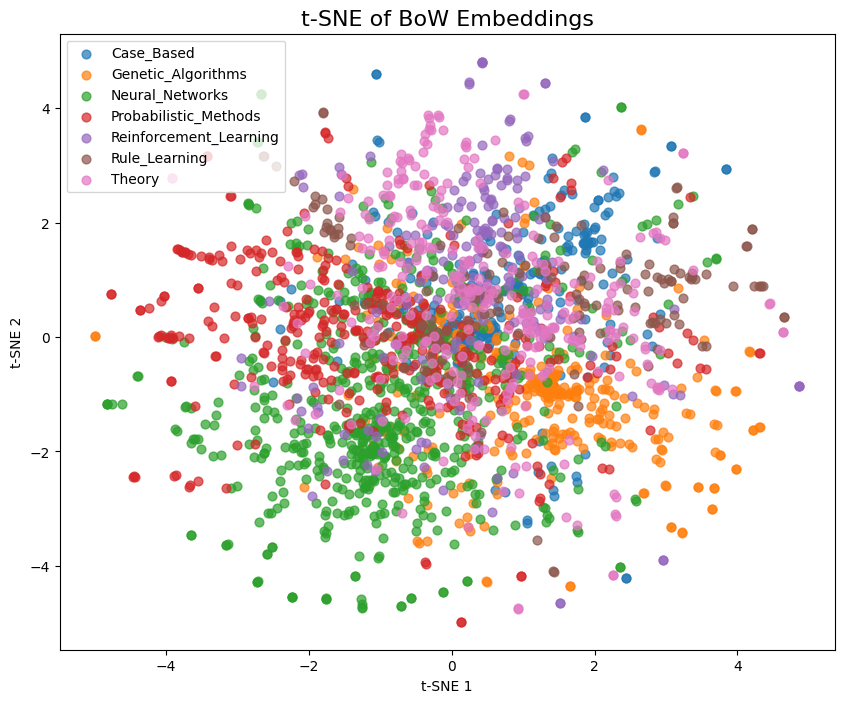

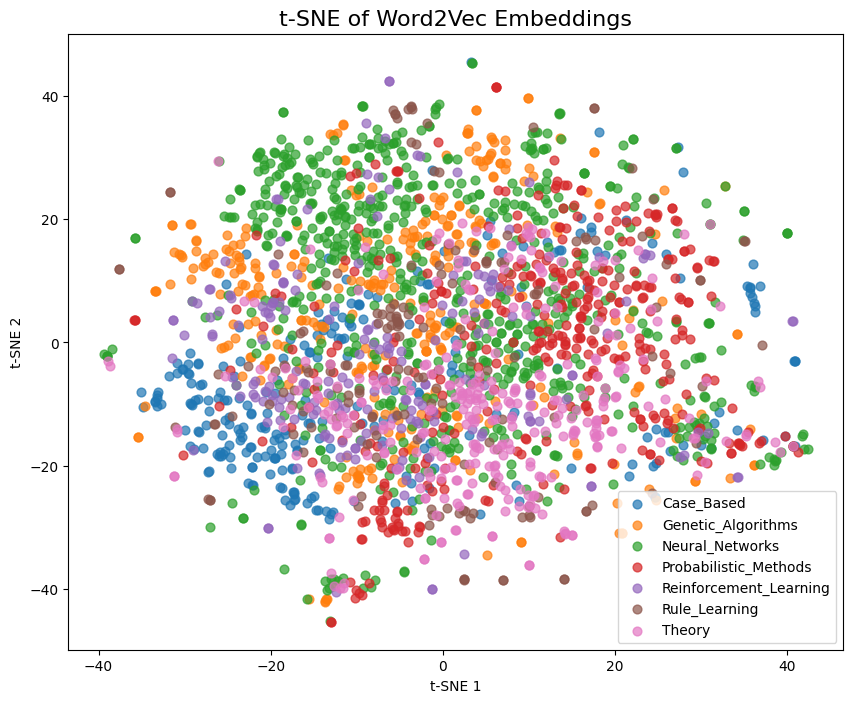

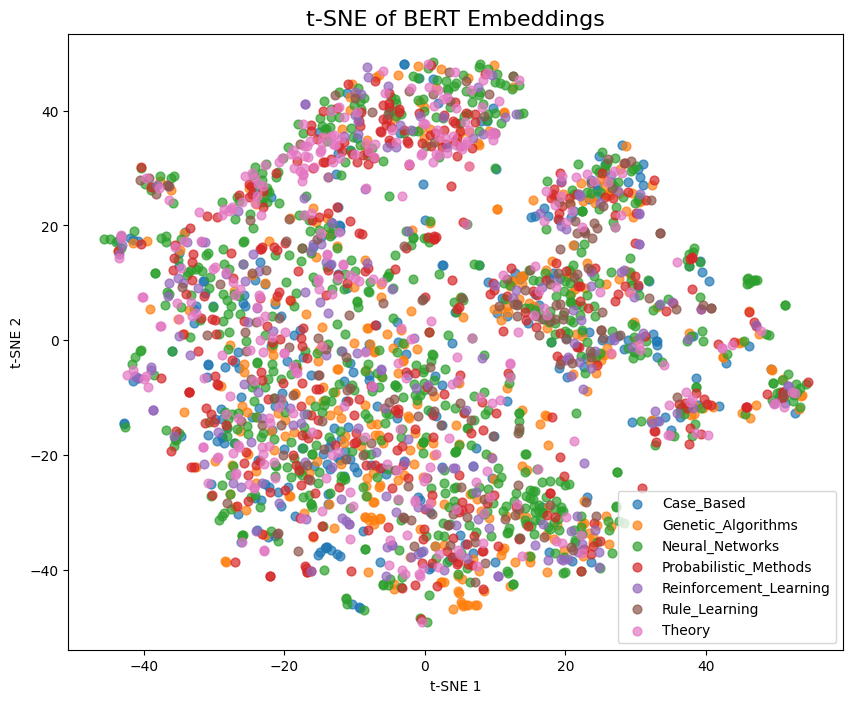

In [ ]:
# Function to plot t-SNE
def plot_tsne(X, labels, class_names, title, perplexity=30, random_state=42):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    X_embedded = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idxs = labels == class_idx
        plt.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], label=class_name, alpha=0.7, s=40)
    
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.grid(False)
    plt.show()


y_labels = dataset['label_encoded'].values
class_names = le.classes_


plot_tsne(np.vstack(dataset['BoW'].values), y_labels, class_names, "t-SNE of BoW Embeddings")
plot_tsne(np.vstack(dataset['Abstract_W2V'].values), y_labels, class_names, "t-SNE of Word2Vec Embeddings")
plot_tsne(np.vstack(dataset['bert_embedding'].values), y_labels, class_names, "t-SNE of BERT Embeddings")
